In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
df = pd.read_csv("quora_duplicate_questions.csv")
df.head() 

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
df.shape

(404290, 6)

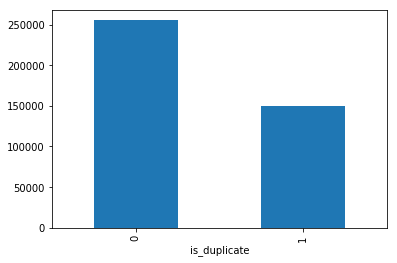

In [7]:
df.groupby("is_duplicate")['id'].count().plot.bar()
plt.show()

In [50]:
print('Total question pairs:{}'.format(len(df)))
print("Duplicate pairs:%.2f%%" % (df['is_duplicate'].mean()*100))
print('Total no. of unique questions in dataset:{}'.format(len(np.unique(qid))))
print('No. of questions that appear multiple times: {}'.format(np.sum(qid.value_counts()>1)))

Total question pairs:404290
Duplicate pairs:36.92%
Total no. of unique questions in dataset:537933
No. of questions that appear multiple times: 111780


In [21]:
df['is_duplicate'].mean()*100

36.9197853026293

In [37]:
qid=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())

In [38]:
len(np.unique(qid))

537933

In [40]:
print('Total no. of unique questions in dataset:{}'.format(len(np.unique(qid))))

Total no. of unique questions in dataset:537933


In [49]:
print('No. of questions that appear multiple times: {}'.format(np.sum(qid.value_counts()>1)))

No. of questions that appear multiple times: 111780


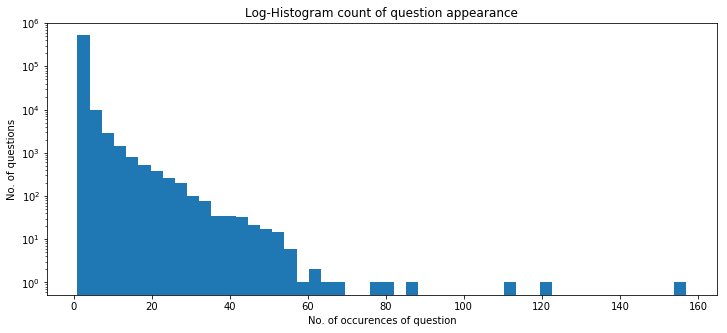

In [62]:
plt.figure(figsize=(12, 5))
plt.hist(qid.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram count of question appearance')
plt.xlabel('No. of occurences of question')
plt.ylabel('No. of questions')
plt.show()

In [74]:
from sklearn.model_selection import train_test_split

train_data_raw, test_data_raw = train_test_split(df, test_size=0.2)

In [73]:
#Function to calculate normalized word share between two questions
def word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [77]:
#Combine all questions into corpus for analysis similar to Term-frequency in TFIDF
train_questions = pd.Series(train_data_raw['question1'].tolist() + train_data_raw['question2'].tolist()).astype(str)
test_questions = pd.Series(test_data_raw['question1'].tolist() + test_data_raw['question2'].tolist()).astype(str)
#Implement TFIDF function
def get_weight(count, eps=5000, min_count=2):
    if count < min_count:
        return 0 #remove words only appearing once 
    else:
        R = 1.0 / (count + eps)
        return R

eps = 5000 
words = (" ".join(train_questions)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
print "Most common words: ", (sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])

Most common words:  [('the', 3.2706887416352137e-06), ('what', 3.9384188823554895e-06), ('is', 4.539305849349517e-06), ('how', 5.555246930726071e-06), ('i', 5.707111060381235e-06), ('a', 5.762061435099021e-06), ('to', 5.955890673670794e-06), ('in', 6.22610731318565e-06), ('of', 7.581558616820446e-06), ('do', 7.773269281594452e-06)]


In [78]:
#Calculate TFIDF word match share as our new feature
def tfidf_word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" "))) 
    if len(w1)==0 or len(w2)==0:
        return 0
    common = w1 & w2
    share_weight = [weights.get(word, 0) for word in common]
    total_weight = [weights.get(word, 0) for word in w1]+[weights.get(word, 0) for word in w2]
    return np.sum(share_weight)/np.sum(total_weight)

In [79]:
#Construct features for training data: character length, number of words, normalized word share 
train_data = pd.DataFrame(dtype='float64')
train_data['q1chrlen'] = train_data_raw['question1'].str.len()
train_data['q2chrlen'] = train_data_raw['question2'].str.len()
train_data['q1_nword'] = train_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
train_data['q2_nword'] = train_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
train_data['word_share'] = train_data_raw.apply(word_share_norm, axis=1)
train_data['TFIDF_share'] = train_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
train_data.head()

,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share,TFIDF_share
77467,57,45.0,9,7,0.187500,0.234044
169198,41,25.0,8,4,0.363636,0.433014
186450,28,29.0,7,7,0.285714,0.225292
389216,32,34.0,6,7,0.307692,0.261585
356832,70,66.0,12,12,0.000000,0.000000


In [80]:
train_data.head()

,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share,TFIDF_share
77467,57,45.0,9,7,0.187500,0.234044
169198,41,25.0,8,4,0.363636,0.433014
186450,28,29.0,7,7,0.285714,0.225292
389216,32,34.0,6,7,0.307692,0.261585
356832,70,66.0,12,12,0.000000,0.000000


In [81]:
#Check if there's NaN values in the data. If yes, replace them.
np.sum(np.isnan(train_data))
train_data.loc[:,'q2chrlen'] = np.nan_to_num(train_data.loc[:,'q2chrlen'])
np.sum(np.isnan(train_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

In [82]:
#Process test data to have the same features as training data
test_data = pd.DataFrame()
test_data['q1chrlen'] = test_data_raw['question1'].str.len()
test_data['q2chrlen'] = test_data_raw['question2'].str.len()
test_data['q1_nword'] = test_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
test_data['q2_nword'] = test_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
test_data['word_share'] = test_data_raw.apply(word_share_norm, axis=1)
test_data['TFIDF_share'] = test_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
#Replace NaN if any
np.sum(np.isnan(test_data))
test_data.loc[:,['q1chrlen','q2chrlen']] = np.nan_to_num(test_data.loc[:,['q1chrlen','q2chrlen']])
np.sum(np.isnan(test_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

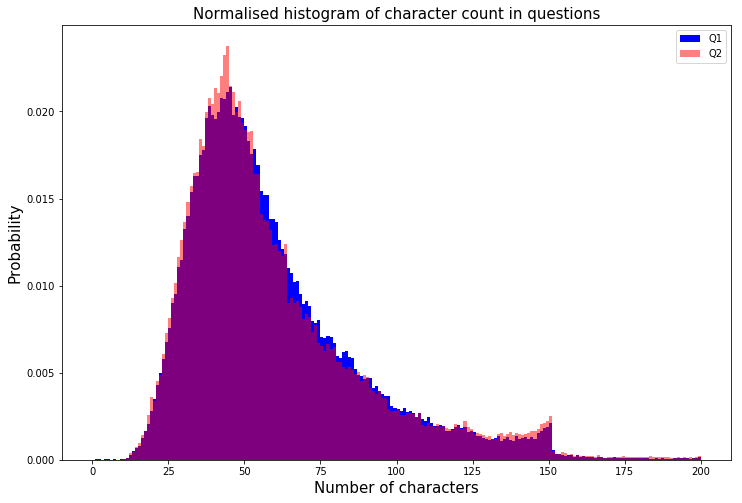

In [84]:

#Get some visual on character count#Get so 
plt.figure(figsize=(12, 8))
plt.hist(train_data['q1chrlen'], bins=200, range=[0, 200], color='blue', normed=True, label='Q1')
plt.hist(train_data['q2chrlen'], bins=200, range=[0, 200], color='red',alpha = 0.5, normed=True, label='Q2')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()

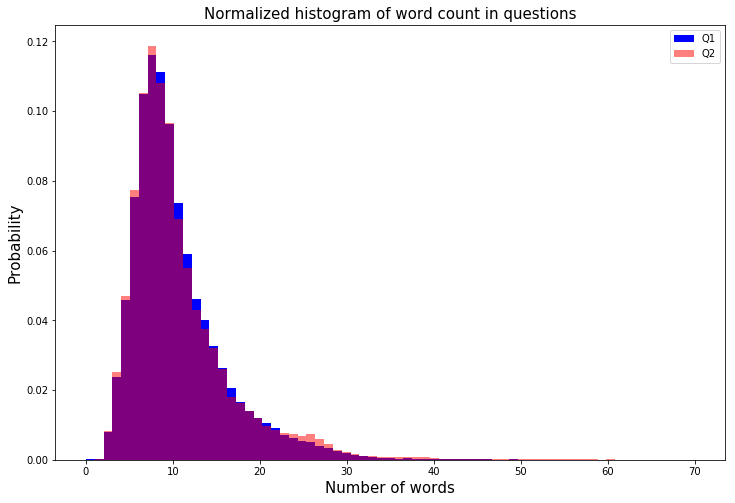

In [85]:
#Get some visual on word count
plt.figure(figsize=(12, 8))
plt.hist(train_data['q1_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='Q1')
plt.hist(train_data['q2_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='Q2')
plt.title('Normalized histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()

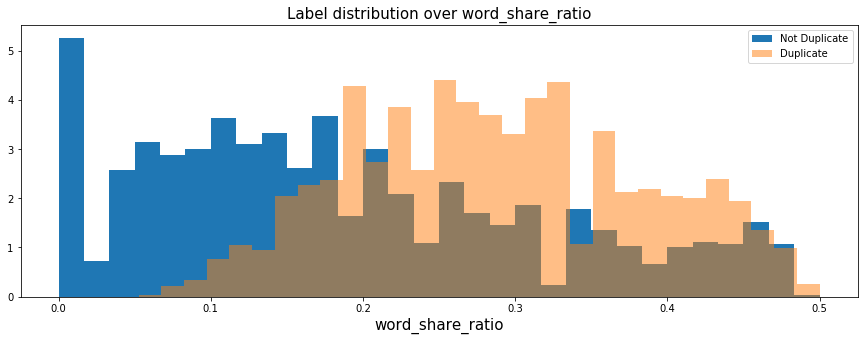

In [91]:
#Get some visual on word share
plt.figure(figsize=(15, 5))
train_word_share = train_data['word_share']
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 0], bins=30, normed=True, label='Not Duplicate')
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 1], bins=30, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_share_ratio', fontsize=15)
plt.xlabel('word_share_ratio', fontsize=15)
plt.show()

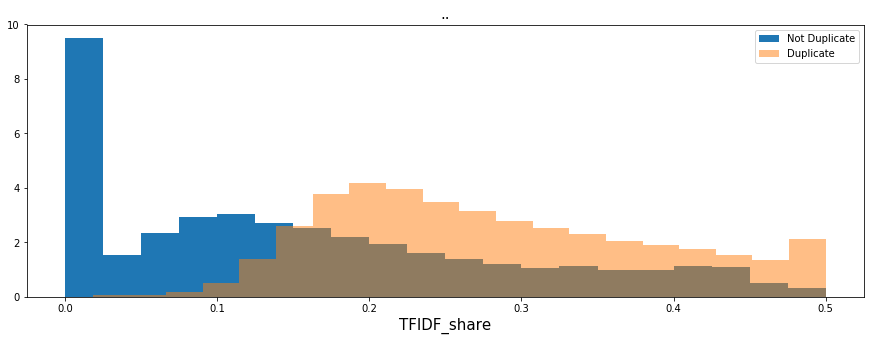

In [94]:
#Get some visual on TFIDF word share
plt.figure(figsize=(15, 5))
train_tfidf = train_data['TFIDF_share'].fillna(0)
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 1], bins=20, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('..', fontsize=15)
plt.xlabel('TFIDF_share', fontsize=15)
plt.show()